In [1]:
''' FUNCTIONS FOR EXTRACTION AND PROCESSING OF DATA WITH EMG RECORDINGS '''
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from emg import EMG_filter
# Get list of files in specific directory with a specified extension (e.g. csv)
def get_files_in_directory(path, extension):
    os.chdir(path)
    result = glob.glob('*.{}'.format(extension))
    result.sort() # Ensure correct order of files
    print(result)
    return result

# Get list of numpy arrays, each corresp. to a csv file in list_files
def array_from_csv(list_files):
    if len(list_files) == 1:
        list_arr = pd.read_csv(list_files[0], sep=',', header=0).values
    else: 
        list_arr = [pd.read_csv(file, sep=',', header=0).values for file in list_files]
    return list_arr

# Shift an EMG recording
def shift(emg):
    avg = np.mean(emg)
    emg_shift_abs = np.abs([elem-avg for elem in emg])
    return emg_shift_abs

# Shift an EMG recording (1D array) to zero-mean level, take absolute value, and normalize wrt. maximum
def shift_abs_normalize_EMG(emg):
    avg = np.mean(emg)
    emg_shift_abs = np.abs([elem-avg for elem in emg])
    maximum = np.max(emg_shift_abs)
    return np.array([elem/maximum for elem in emg_shift_abs])

list_files = get_files_in_directory('C:/Users/Administrator/Desktop/MyoFile/SignalTimeRecord/', 'csv')
list_datasets = array_from_csv(list_files)
print(list_datasets[0])
# A) No flexion
# B) Full flexion, maximal force
# No flexion to:
#      C) Full flexion, minimal force
#      D) Full flexion, maximal force
#      E) Full extension, minimal force
#      F) Full extension, maximal force
#      G) Thumb direction flexion, minimal force
#      H) Thumb direction flexion, maximal force
#      I) Pinky finger flexion, minimal force
#      J) Pinky finger flexion, maximal force
# Part IV: Individual finger movements (prefix "F")
# K) Perpendicular
# L) Covering half the electrode and doing full flexion, maximal force
# M) Reference electrode on elbow
# N) Reference electrode on forehead
# O) Reference electrode right next to recording electrodes

End
['forefinger.csv', 'forefinger1.csv', 'forefinger2.csv', 'forefinger3.csv', 'forefinger4.csv', 'forefinger5.csv', 'littlefinger.csv', 'littlefinger1.csv', 'littlefinger2.csv', 'littlefinger3.csv', 'littlefinger4.csv', 'littlefinger5.csv', 'middlefinger.csv', 'middlefinger1.csv', 'middlefinger2.csv', 'middlefinger3.csv', 'middlefinger4.csv', 'middlefinger5.csv', 'ringfinger.csv', 'ringfinger1.csv', 'ringfinger2.csv', 'ringfinger3.csv', 'ringfinger4.csv', 'ringfinger5.csv', 'thumb.csv', 'thumb2.csv', 'thumb3.csv', 'thumb4.csv', 'thumb5.csv']
[[68 49  0  0  0  0]
 [68 49  0  0  0  0]
 [65 46  0  0  0  0]
 ...
 [55 38  0  0  0  0]
 [63 39  0  0  0  0]
 [59 37  0  0  0  0]]


In [2]:
'''Smoothing algorithms'''

import numpy as np
from math import factorial

# Savitzky-Golay smoothing uses polynomials
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

# Root-mean-square smoothing uses convolution with a square pulse
def window_rms(array, window_size):
    array_squared = np.power(array, 2)               # Square each element of array
    window = np.ones(window_size)/float(window_size) # Repr. square pulse whose width is the window size
    return np.sqrt(np.convolve(array_squared, window, 'valid'))

[ 20  20  20  26  24  28  27  27  25  25  34  34  33  49  46  44  41  40
  37  37  36  58  54  51  48  46  43  42  42  40  38  39  37  45  43  44
  41  41  41  39  37  37  35  34  32  40  39  37  37  39  37  36  34  39
  37  37  35  35  38  43  40  47  44  46  44  44  44  42  45  44  41  44
  41  43  41  47  47  46  52  53  50  50  48  52  49  47  47  47  45  52
  49  88  84 240 228 228 221 211 204 196 187 181 173 173 168 161 155 150
 144 138 134 129 123 123 119 115 110 106 102  99  94  91  91  88  85  81
  78  75  72  69  67  67  64  61  59  56  54  53  50  48  48  46  44  42
  40  39  37  37  34  35  35  50  48  45  42  40  38  40  38  38  36  41
  38  37  35  36  33  33  34  34  59  56  52  50  48  46  43  41  41  39
  37  40  37  36  35  35  33  40  40  41  38  45  43  42  40  39  37  37
  35  44  41  47  45  42  40  39  37  37  37  38  36  34  33  35  33  32
  32  30  30  51  48  46  44  41  39  38  38  40  37  39  37  36  34  33
  32  32  30  53  50  49  47  45  43  41  88  88 11

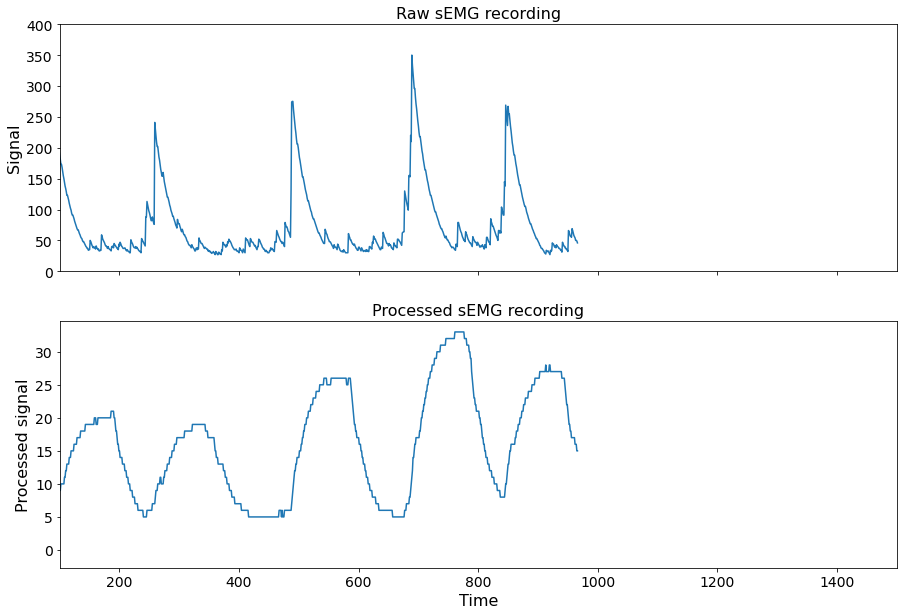

In [7]:
# EXAMPLE
#data[0][0][0] First index: dataset. Second index: time series. Third: which time step.

# Process a raw sEMG recording and plot both the raw and processed signals
def plot_sEMG(experiment, run, smoothing_algo = 'rms'):
#     raw_semg = list_datasets[experiment][:,run] # [3][0] is a good example
#     shifted_semg = shift(raw_semg)
#     processed_semg = shift_abs_normalize_EMG(raw_semg)
    
#     # Choose algorithm used for smoothening of sEMG signal
#     if smoothing_algo == 'savitzky_golay':
#         smooth_semg = savitzky_golay(shifted_semg, 101, 1)
#     elif smoothing_algo == 'rms':
#         smooth_semg = window_rms(shifted_semg, 100)
    raw_semg = list_datasets[experiment][:,run]
    print(raw_semg)
    emgFilter = EMG_filter()
    smooth_semg = []
    for i in raw_semg:
        smooth_semg.append(emgFilter.filter(i))
    f, axs = plt.subplots(2, sharex='col')
    axs[0].plot(raw_semg)
    axs[0].set_ylabel('Signal', fontsize=16)
    axs[0].set_title('Raw sEMG recording', fontsize=16)
    axs[0].tick_params(labelsize=14)
    axs[0].set_ylim(0, 400)
    axs[0].set_xlim(100, 1500)
    
    axs[1].plot(smooth_semg)
    axs[1].set_ylabel('Processed signal', fontsize=16)
    axs[1].set_xlabel('Time', fontsize=16)
    axs[1].set_title('Processed sEMG recording', fontsize=16)
    axs[1].tick_params(labelsize=14)
    #axs[1].set_ylim(0,20000)
    axs[0].set_xlim(100, 1500)

    plt.rcParams['figure.figsize'] = [15, 10]
    plt.show()
    
    return None

plot_sEMG(5,1)

In [39]:
#output the processed data into csv
count = 0
for dataset in list_datasets:
    count=count+1
    filter_list = []
    for col in range(6):
        raw_semg = dataset[:,col]
        emgFilter = EMG_filter()
        smooth_semg = []
        for i in raw_semg:
            smooth_semg.append(emgFilter.filter(i))
        filter_list.append(smooth_semg)
   # print(filter_list)
    filter_arr = np.array(filter_list)
    res = []
    for col in range(filter_arr.shape[1]):
        res.append(filter_arr[:,col])
    res_arr = np.array(res)
    pd_data = pd.DataFrame(res_arr)  
    pd_data.to_csv('pd_data'+str(count)+ '.csv',index = False, header=False) 
    

In [26]:
# The different experiments
expts_AO = list_files[:14]
expts_fingers = list_files[14:30]
expts_perp = list_files[-4:] # Last four elements

In [27]:
expts_perp

['2021-04-19_14-50-34.csv', '2021-04-19_14-51-02.csv']

In [28]:
'''Compute standard deviation or noise'''
sd = np.mean([np.std(elem) for elem in list_datasets[0]])
print(f"The standard deviation is: {sd}")

def signaltonoise(a):
    a = np.asanyarray(a)
    m = a.mean()
    sd = a.std()
    return np.where(sd == 0, 0, m/sd)

snr = signaltonoise(list_datasets[0][0])
print(f"The signal-to-noise ratio is: {snr}")



The standard deviation is: 48.70931334071024
The signal-to-noise ratio is: 0.4472135954999579
